In [ ]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 38.70 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Input,Activation
import cv2
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Model
from imgaug import augmenters as iaa

In [ ]:
dir='track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(dir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

<ipython-input-3-74cf4d34385e>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [ ]:
def pathsplit(data):
  head,tail=ntpath.split(data)
  return tail

data['center']=data['center'].apply(pathsplit)
data['left']=data['left'].apply(pathsplit)
data['right']=data['right'].apply(pathsplit)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


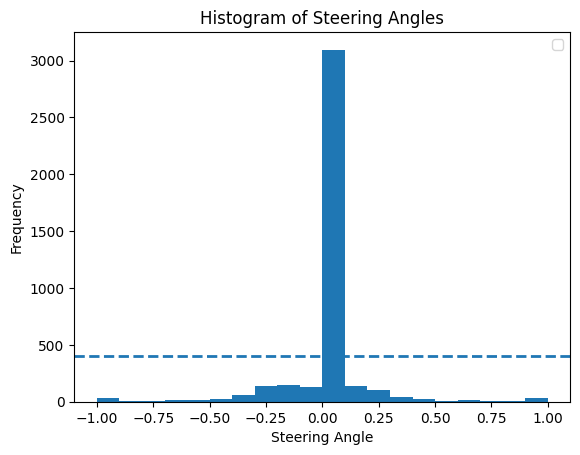

In [ ]:
steering_angles = data['steering']
samples_per_samples=400
plt.hist(steering_angles, bins=20)
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title('Histogram of Steering Angles')
plt.axhline(y=samples_per_samples,linestyle='--', linewidth=2)
plt.legend()  # Show the legend
plt.show()


In [ ]:
print(f'Total no. of images are {len(data)}')

Total no. of images are 4053


In [ ]:
filtered_data = data[data['steering'] <= 400]

In [ ]:
num_bins = 25
samples_per_bin = 400

hist, bins = np.histogram(data['steering'], num_bins)


remove_list = []

for j in range(num_bins):
    indices_in_bin = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            indices_in_bin.append(i)
    random.shuffle(indices_in_bin)
    remove_list.extend(indices_in_bin[samples_per_bin:])

print('removed:', len(remove_list))


data.drop(data.index[remove_list], inplace=True)

print('remaining:', len(data))

removed: 2590
remaining: 1463


In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)

    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths, steerings = load_img_steering(dir + '/IMG', data)

In [ ]:
len(image_paths),len(steerings)

(4389, 4389)

In [ ]:
x_train,x_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=42)
print(f'No of Training Samples {len(x_train)}')
print(f'No of Validation Samples {len(x_valid)}')

No of Training Samples 3511
No of Validation Samples 878


In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image


In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #for nvidia model
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))  #input size of nvidia model
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

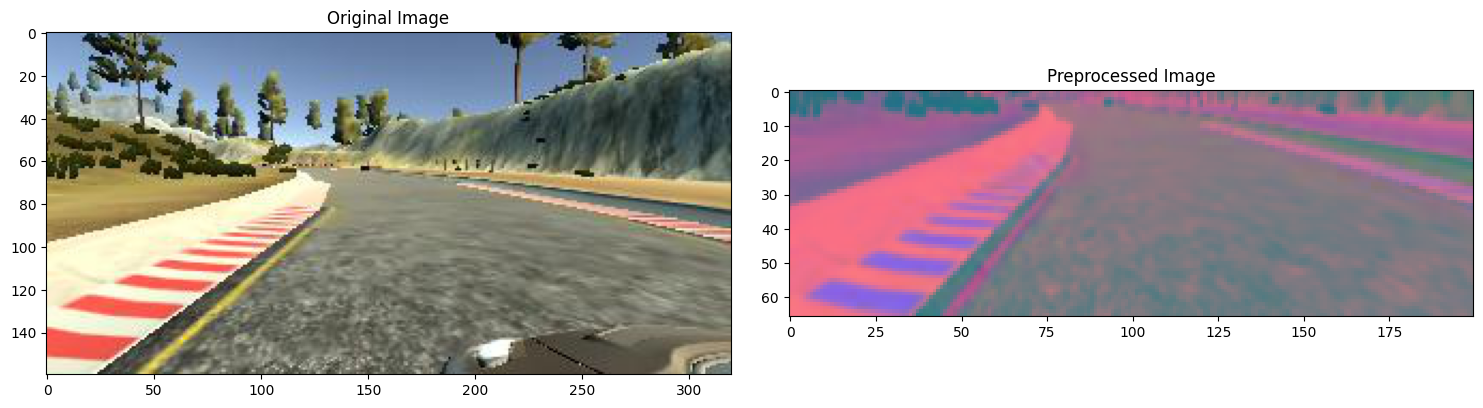

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

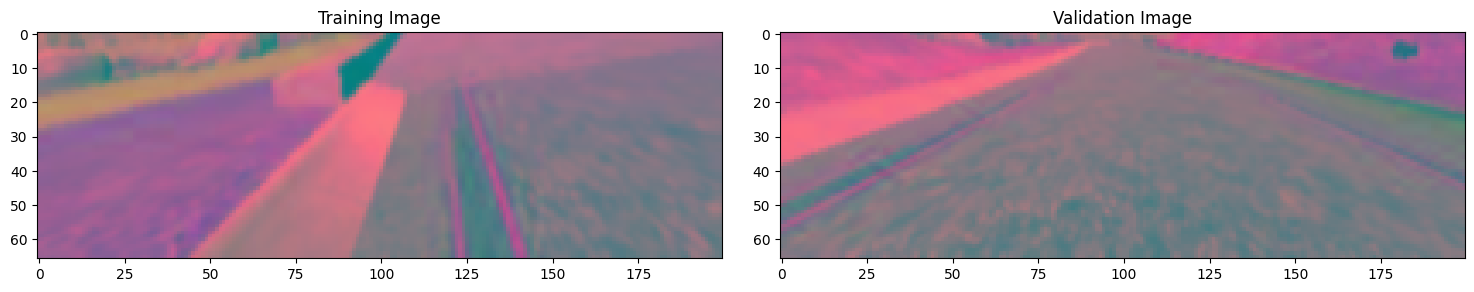

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
def nvidia_model(input_shape):
  input_ = Input(shape=input_shape)
  x=Conv2D(24,(5,5),strides=(2,2))(input_)
  x=Activation('elu')(x)

  x=Conv2D(36,(5,5),strides=(2,2))(x)
  x=Activation('elu')(x)

  x=Conv2D(48,(5,5),strides=(2,2))(x)
  x=Activation('elu')(x)

  x=Conv2D(64,(5,5))(x)
  x=Activation('elu')(x)


  x=Flatten()(x)

  x=Dense(100, activation = 'elu')(x)
  x=Dense(50, activation = 'elu')(x)
  x=Dense(10, activation = 'elu')(x)
  x=Dense(1)(x)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model=Model(input_,x)
  model.compile(loss='mse', optimizer=optimizer,metrics=['accuracy'])
  return model

In [ ]:
input_shape=(66, 200, 3)
model = nvidia_model(input_shape)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 66, 200, 3)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 activation_4 (Activation)   (None, 31, 98, 24)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 activation_5 (Activation)   (None, 14, 47, 36)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 activation_6 (Activation)   (None, 5, 22, 48)         0   

In [ ]:
history = model.fit_generator(batch_generator(x_train, y_train, 100, 1),steps_per_epoch=300,epochs=20,validation_data=batch_generator(x_valid, y_valid, 100, 0),
                                  validation_steps=200,verbose=1,shuffle = True)

<ipython-input-35-e9ca912762b5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(x_train, y_train, 100, 1),steps_per_epoch=300,epochs=20,validation_data=batch_generator(x_valid, y_valid, 100, 0),


Epoch 1/20
300/300 [==============================] - 152s 463ms/step - loss: 0.0928 - val_loss: 0.0654
Epoch 2/20
300/300 [==============================] - 142s 476ms/step - loss: 0.0646 - val_loss: 0.0491
Epoch 3/20
300/300 [==============================] - 138s 461ms/step - loss: 0.0556 - val_loss: 0.0367
Epoch 4/20
300/300 [==============================] - 137s 460ms/step - loss: 0.0503 - val_loss: 0.0333
Epoch 5/20
300/300 [==============================] - 139s 464ms/step - loss: 0.0466 - val_loss: 0.0328
Epoch 6/20
300/300 [==============================] - 144s 481ms/step - loss: 0.0436 - val_loss: 0.0283
Epoch 7/20
300/300 [==============================] - 145s 485ms/step - loss: 0.0420 - val_loss: 0.0356
Epoch 8/20
300/300 [==============================] - 141s 470ms/step - loss: 0.0408 - val_loss: 0.0290
Epoch 9/20
300/300 [==============================] - 140s 469ms/step - loss: 0.0396 - val_loss: 0.0268
Epoch 10/20
300/300 [==============================] - 144s 480m

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>